# LSTM

In [34]:
!pip install googletrans

  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.


In [35]:
!pip install wordcloud

In [1]:
# utility
import numpy as np 
import pandas as pd 
import string
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# model 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
import keras
from keras.utils.np_utils import to_categorical

#nltk and sklearn
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

### Data

In [2]:
# original hindi file
filename  = '../../Eng-Hin-data/english-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [3]:
# Displaying eg tweet before translation
orig_df.Text[2]

"'Thorpe becomes England head coach for Pakistan T20 series with Silverwood rested"

In [5]:
df = orig_df
df.head()

,Text,Label
0,'@Cricket_Mann And they will see more of it no...,0
1,"""Juma'at Kareem to all my Muslim brother aroun...",1
2,'Thorpe becomes England head coach for Pakista...,0
3,'@ParZevil Plymouth Cricket. THREE transmissions.,0
4,'jungkook didnâ€™t get caught eating food duri...,1


In [40]:
sentiment =  df['Label'].values

In [41]:
df.groupby('Label').describe()

Text                                                               
      count unique                                                top freq
Label                                                                     
0      3555   3555                '@outroKay me with the cricket ðŸ˜£    1
1      2398   2398  'mohammed minghao my little muslim brother ðŸ¥...    1
2      2484   2484  '@DVATW She is well known jehadi supporter   e...    1

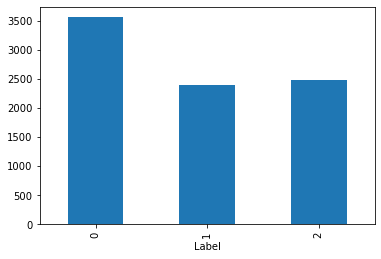

In [42]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [43]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

0    3555
2    2485
1    2398
Name: Label, dtype: int64

### Balanced Data

In [44]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [45]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [46]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([df, data])

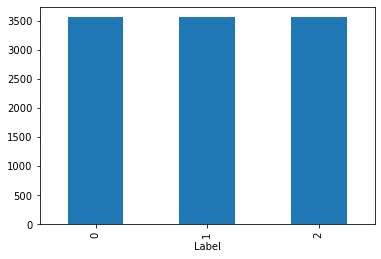

In [47]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [48]:
data.Label.value_counts()

0    3555
1    3554
2    3554
Name: Label, dtype: int64

In [49]:
# For entire dataset sentences for each labels 
data.Label.value_counts()

0    3555
1    3554
2    3554
Name: Label, dtype: int64

In [50]:

data=data.sample(frac=1).reset_index(drop=True)
data

,Text,Label
0,'@IsraeliPM Just flush this Islamic terrorism,2
1,'@PTTVOnlineNews This is the one of the rule o...,0
2,'@WisdenCricket One of the best sights in cric...,0
3,'Happy #muharram to our Islamic clients colle...,1
4,'@seanhannity Yes Omar is advocate of Marxism ...,2
...,...,...
10658,'#Covid_19 #Cricket #WeMissYouShehnaaz @WHO,0
10659,'@Muzammi98268225 End of Islamic terrorism in ...,2
10660,'Discover Quran Verses about #Sabeans @ [5:69]...,1
10661,'@erbmjha @ggiittiikkaa The best definition of...,2


### Data Preprocessing

In [51]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [52]:
def CleanTokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            line = clean_text(line)
        else:
            continue
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        tweets.append(words)
    return tweets

def Tokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            # tokenize the text
            tokens = word_tokenize(line)
        else:
            continue

        tweets.append(tokens)
    return tweets

tweets = CleanTokenize(data)
#tweets = Tokenize(data)


(-0.5, 999.5, 499.5, -0.5)

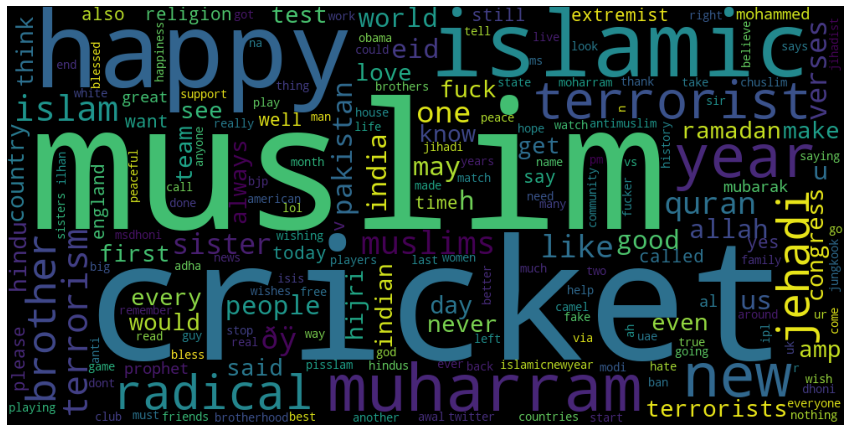

In [53]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['Label'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### Splitting data

In [54]:
validation_split = 0.1
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['Label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

le = LabelEncoder()
sentiment = le.fit_transform(sentiment)
# transfor from a array to a vector
sentiment = sentiment.reshape(-1,1)


num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]

X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


unique tokens -  14306
vocab size - 14307


In [55]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (9596, 25)
Shape of y_train: (9596, 3)
Shape of X_test_pad: (1066, 25)
Shape of y_test: (1066, 3)


### Word2vec Word Embedding

In [56]:
from gensim import models
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [57]:
embedding_dim = 300

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i,:] = word2vec[word] if word in word2vec else np.random.rand(embedding_dim)
print()

In [58]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## LSTM Model

In [59]:
from tensorflow.keras import optimizers
def createModel(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.50))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate=1e-3), metrics=['acc'])
    return model

model = createModel(embedding_layer)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 300)           4292100   
                                                                 
 lstm_11 (LSTM)              (None, 256)               570368    
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 4,863,239
Trainable params: 571,139
Non-trainable params: 4,292,100
_________________________________________________________________


In [60]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/6
300/300 - 47s - loss: 0.9992 - acc: 0.5488 - val_loss: 0.9823 - val_acc: 0.5891 - 47s/epoch - 158ms/step
Epoch 2/6
300/300 - 61s - loss: 0.9553 - acc: 0.5962 - val_loss: 0.9577 - val_acc: 0.5891 - 61s/epoch - 204ms/step
Epoch 3/6
300/300 - 43s - loss: 0.9467 - acc: 0.6007 - val_loss: 0.9529 - val_acc: 0.5929 - 43s/epoch - 143ms/step
Epoch 4/6
300/300 - 41s - loss: 0.9409 - acc: 0.6071 - val_loss: 0.9592 - val_acc: 0.5816 - 41s/epoch - 138ms/step
Epoch 5/6
300/300 - 41s - loss: 0.9337 - acc: 0.6085 - val_loss: 0.9505 - val_acc: 0.5938 - 41s/epoch - 138ms/step
Epoch 6/6
300/300 - 41s - loss: 0.9297 - acc: 0.6130 - val_loss: 0.9479 - val_acc: 0.6004 - 41s/epoch - 137ms/step


In [61]:
results = model.evaluate(X_test_pad, y_test, batch_size=32)

34/34 [==============================] - 1s 36ms/step - loss: 0.9479 - acc: 0.6004


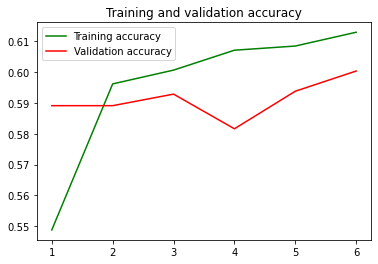

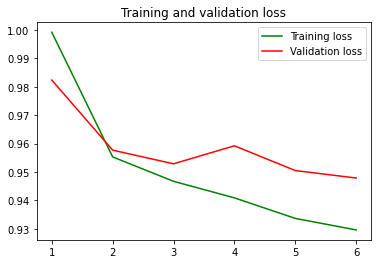

In [62]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 10 Fold cross validation

In [63]:
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold
# KFold cross-validation
kFold = 10
scores = []
validation_split = 0.1
max_length = 25
results = []
train_results = []
print("LSTM with Word2Vec: ")
for i in range(kFold):
    print("Fold: ", i+1)
    prediction_val = []
    Y_test = []
    scores=[]
    random_shuff = random.randint(1, 7000)
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(lines_pad, to_categorical(sentiment), test_size=0.10, shuffle = True, random_state=random_shuff)
    model = createModel(embedding_layer)
    history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=1)
    
    print("Results for current fold:")
    print("Evaluation using training data")
    train_results.append(model.evaluate(X_train_pad, y_train, batch_size=128))
    print("Evaluation using testing data")
    results.append(model.evaluate(X_test_pad, y_test, batch_size=128))
    
    y_pred = model.predict(X_test_pad)
    for p in y_pred:
        prediction_val.append(np.argmax(p))
    for t in y_test:
        Y_test.append(np.argmax(t))
    scoreValue = accuracy_score(Y_test,prediction_val)
    scores.append(scoreValue)



LSTM with Word2Vec: 
Fold:  1
Epoch 1/6
300/300 [==============================] - 47s 148ms/step - loss: 1.0003 - acc: 0.5546 - val_loss: 0.9515 - val_acc: 0.5914
Epoch 2/6
300/300 [==============================] - 45s 149ms/step - loss: 0.9568 - acc: 0.5919 - val_loss: 0.9380 - val_acc: 0.6045
Epoch 3/6
300/300 [==============================] - 47s 157ms/step - loss: 0.9495 - acc: 0.5973 - val_loss: 0.9790 - val_acc: 0.5595
Epoch 4/6
300/300 [==============================] - 43s 144ms/step - loss: 0.9438 - acc: 0.6038 - val_loss: 0.9435 - val_acc: 0.6036
Epoch 5/6
300/300 [==============================] - 43s 144ms/step - loss: 0.9362 - acc: 0.6080 - val_loss: 0.9327 - val_acc: 0.6064
Epoch 6/6
300/300 [==============================] - 43s 142ms/step - loss: 0.9322 - acc: 0.6115 - val_loss: 0.9277 - val_acc: 0.6157
Results for current fold:
Evaluation using training data
75/75 [==============================] - 5s 71ms/step - loss: 0.9218 - acc: 0.6224
Evaluation using testing d

In [64]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.6056232452392578


### Confusion matrix

In [65]:
#for last fold
results2 = confusion_matrix(Y_test,prediction_val)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(Y_test,prediction_val))
print ('Report : ')
print (classification_report(Y_test,prediction_val))

Confusion Matrix :
[[229  63  83]
 [ 76 223  72]
 [ 60  59 202]]
Accuracy Score : 0.612933458294283
Report : 
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       375
           1       0.65      0.60      0.62       371
           2       0.57      0.63      0.60       321

    accuracy                           0.61      1067
   macro avg       0.61      0.61      0.61      1067
weighted avg       0.62      0.61      0.61      1067

